In [1]:
import numpy as np
from scipy.linalg import inv, eigvals, norm
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm
from joblib import Parallel, delayed
from multiprocessing import Manager

from utils import *
from models.tvgti_pc_nonsparse import TimeVaryingSEM as TimeVaryingSEM_PC_NONSPARSE
from models.tvgti_pp_nonsparse_undirected import TimeVaryingSEM as TimeVaryingSEM_PP_NONSPARSE_UNDIRECTED

In [2]:
def generate_random_S(N, sparsity, max_weight):
    S = np.zeros((N, N))
    
    for i in range(N):
        for j in range(i + 1, N):
            if np.random.rand() < sparsity:
                weight = np.random.uniform(-max_weight, max_weight)
                # weight = np.random.uniform(0, max_weight)
                S[i, j] = weight
                S[j, i] = weight
    
    # Ensure spectral radius < 1
    spectral_radius = max(abs(eigvals(S)))
    if spectral_radius >= 1:
        S = S / (spectral_radius + 0.1)

    S = S / norm(S)
    return S

def generate_random_S_with_off_diagonal(N, sparsity, max_weight):
    S = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            if i != j and np.random.rand() < sparsity:
                weight = np.random.uniform(-max_weight, max_weight)
                # weight = np.random.uniform(0, max_weight)
                S[i, j] = weight
    
    # Ensure spectral radius < 1
    spectral_radius = max(abs(eigvals(S)))
    if spectral_radius >= 1:
        S = S / (spectral_radius + 0.1)

    S = S / norm(S)
    return S

def modify_S(S, edge_indices, factor=2.0):
    S_modified = S.copy()
    for (i, j) in edge_indices:
        if i != j:
            S_modified[i, j] *= factor
            S_modified[j, i] *= factor
    return S_modified

def generate_stationary_X(N, T, S_is_symmetric, sparsity, max_weight, std_e):
    if S_is_symmetric:
        S = generate_random_S(N, sparsity=sparsity, max_weight=max_weight)
    else:
        S = generate_random_S_with_off_diagonal(N, sparsity=sparsity, max_weight=max_weight)
    S_series = [S for _ in range(T)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S = inv(I - S)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X = inv_I_S @ e_t_series

    return S_series, X, e_t_series

def generate_stationary_X_from_S(S, N, T, std_e):
    S = S
    S_series = [S for _ in range(T)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S = inv(I - S)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X = inv_I_S @ e_t_series

    return S_series, X

def generate_piecewise_X(N, T, S_is_symmetric, sparsity, max_weight, std_e):
    max_weight_0 = max_weight
    max_weight_1 = max_weight
    if S_is_symmetric:
        S0 = generate_random_S(N, sparsity=sparsity, max_weight=max_weight)
    else:
        S0 = generate_random_S_with_off_diagonal(N, sparsity=sparsity, max_weight=max_weight)
    # S1 = generate_random_S(N, sparsity=sparsity, max_weight=max_weight_1)
    S1 = S0*2
    S_series = [S0 for _ in range(T // 2)] + [S1 for _ in range(T - T // 2)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S0 = inv(I - S0)
        inv_I_S1 = inv(I - S1)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X0 = inv_I_S0 @ e_t_series[:, :T // 2]
    X1 = inv_I_S1 @ e_t_series[:, T // 2:]
    X = np.concatenate([X0, X1], axis=1)

    return S_series, X

def generate_piecewise_X_K(N, T, S_is_symmetric, sparsity, max_weight, std_e, K):
    S_list = []
    inv_I_S_list = []
    I = np.eye(N)

    for i in range(K):
        if S_is_symmetric:
            S = generate_random_S(N, sparsity=sparsity, max_weight=max_weight)
        else:
            S = generate_random_S_with_off_diagonal(N, sparsity=sparsity, max_weight=max_weight)
        S_list.append(S)
        try:
            inv_I_S = inv(I - S)
            inv_I_S_list.append(inv_I_S)
        except np.linalg.LinAlgError:
            raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    # Divide T into K segments
    segment_lengths = [T // K] * K
    segment_lengths[i-1] += T % K

    # Create S_series
    S_series = []
    for i, length in enumerate(segment_lengths):
        S_series.extend([S_list[i]] * length)

    # Generate error terms
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    # Compute X
    X_list = []
    start = 0
    for i, length in enumerate(segment_lengths):
        end = start + length
        X_i = inv_I_S_list[i] @ e_t_series[:, start:end]
        X_list.append(X_i)
        start = end

    X = np.concatenate(X_list, axis=1)

    return S_series, X


def solve_offline_sem(X_up_to_t, lambda_reg):
    N, t = X_up_to_t.shape
    S = cp.Variable((N, N), symmetric=True)
    
    # objective = (1/(2*t)) * cp.norm(X_up_to_t - S @ X_up_to_t, 'fro') + lambda_reg * cp.norm1(S)
    objective = (1/(2*t)) * cp.norm(X_up_to_t - S @ X_up_to_t, 'fro')
    
    constraints = [cp.diag(S) == 0]
    
    prob = cp.Problem(cp.Minimize(objective), constraints)
    
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("CVXPY did not find an optimal solution.")
    
    S_opt = S.value
    return S_opt


Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  21%|██        | 1054/5000 [00:02<00:10, 360.98it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:  25%|██▍       | 1241/5000 [00:03<00:09, 410.37it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   0%|          | 0/5000 [00:00<?, ?it/s] 360.85it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  28%|██▊       | 1401/5000 [00:03<00:10, 348.56it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  29%|██▉       | 1439/5000 [00:04<00:12, 281.89it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  13%|█▎        | 672/5000 [00:01<00:06, 626.02it/s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:   7%|▋         | 371/5000 [00:00<00:12, 363.83it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:   7%|▋         | 353/5000 [00:01<00:17, 266.95it/s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   6%|▋         | 322/5000 [00:00<00:07, 589.46it/s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pp_nonsparse:  97%|█████████▋| 4836/5000 [00:08<00:00, 174.07it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pp_nonsparse:  98%|█████████▊| 4893/5000 [00:09<00:00, 124.50it/s]t/s]s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  18%|█▊        | 915/5000 [00:02<00:08, 473.82it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:  24%|██▍       | 1209/5000 [00:03<00:18, 205.47it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  32%|███▏      | 1583/5000 [00:06<00:21, 156.48it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  32%|███▏      | 1624/5000 [00:06<00:19, 171.87it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  35%|███▌      | 1750/5000 [00:07<00:23, 139.71it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:  38%|███▊      | 1891/5000 [00:08<00:14, 218.57it/s]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  19%|█▉        | 956/5000 [00:06<01:09, 58.54it/s] 

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   0%|          | 1/5000 [00:00<22:05,  3.77it/s]s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   1%|          | 44/5000 [00:01<02:51, 28.92it/s]s] 

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:  15%|█▍        | 744/5000 [00:08<01:30, 46.86it/s]]]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  14%|█▍        | 722/5000 [00:07<00:50, 85.24it/s]]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  15%|█▍        | 737/5000 [00:07<00:56, 75.82it/s]] 

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   1%|          | 28/5000 [00:00<01:42, 48.45it/s]]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  24%|██▍       | 1210/5000 [00:10<00:41, 90.53it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  32%|███▏      | 1594/5000 [00:12<00:36, 92.19it/s] 

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:  24%|██▍       | 1199/5000 [00:11<00:47, 79.77it/s] 

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   4%|▎         | 184/5000 [00:03<02:35, 30.88it/s]] 

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   1%|          | 55/5000 [00:01<02:50, 29.05it/s]s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   4%|▍         | 206/5000 [00:04<02:51, 27.92it/s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  26%|██▌       | 1311/5000 [00:13<01:32, 39.99it/s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   1%|▏         | 66/5000 [00:01<01:14, 66.51it/s]]s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:   2%|▏         | 80/5000 [00:02<02:09, 37.87it/s]]] 

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   1%|▏         | 66/5000 [00:00<01:07, 73.63it/s]s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:   3%|▎         | 156/5000 [00:01<00:38, 126.80it/s]]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  10%|▉         | 496/5000 [00:07<00:52, 86.44it/s]  

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:  10%|▉         | 476/5000 [00:08<00:46, 97.92it/s]  

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  24%|██▍       | 1217/5000 [00:12<00:27, 135.76it/s]:10<00:44, 93.83it/s] 

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  45%|████▍     | 2231/5000 [00:24<00:26, 103.89it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:  30%|██▉       | 1495/5000 [00:13<00:11, 302.25it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:   0%|          | 2/5000 [00:00<04:29, 18.53it/s]t/s]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:  35%|███▍      | 1727/5000 [00:16<00:34, 96.18it/s]]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   1%|          | 51/5000 [00:00<01:25, 57.64it/s]]s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:  79%|███████▉  | 3939/5000 [00:28<00:07, 141.55it/s]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:  37%|███▋      | 1861/5000 [00:17<00:23, 131.22it/s]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:  71%|███████   | 3559/5000 [00:28<00:05, 241.99it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:  41%|████      | 2034/5000 [00:21<00:26, 110.56it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:   3%|▎         | 150/5000 [00:01<00:18, 264.38it/s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:   1%|          | 52/5000 [00:00<00:24, 198.10it/s]s] 

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:   0%|          | 3/5000 [00:00<08:28,  9.83it/s]s] ]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   8%|▊         | 376/5000 [00:03<00:24, 188.05it/s]]s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:   9%|▉         | 470/5000 [00:04<00:25, 175.43it/s]]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   3%|▎         | 141/5000 [00:01<00:28, 172.98it/s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  39%|███▉      | 1957/5000 [00:19<00:23, 128.10it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:   6%|▌         | 307/5000 [00:02<00:52, 88.85it/s] ]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  39%|███▊      | 1931/5000 [00:16<00:24, 127.53it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  47%|████▋     | 2364/5000 [00:25<00:33, 78.38it/s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npzLoaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:  57%|█████▋    | 2838/5000 [00:28<00:20, 103.48it/s]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:  19%|█▉        | 966/5000 [00:07<00:48, 83.38it/s] ]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:  58%|█████▊    | 2914/5000 [00:29<00:25, 81.13it/s] 

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  18%|█▊        | 884/5000 [00:07<00:46, 88.12it/s]s]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  64%|██████▍   | 3188/5000 [00:29<00:15, 116.55it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   2%|▏         | 122/5000 [00:01<00:41, 117.49it/s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:   6%|▋         | 322/5000 [00:03<00:32, 143.28it/s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:  58%|█████▊    | 2895/5000 [00:22<00:06, 323.24it/s]]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:  53%|█████▎    | 2636/5000 [00:24<00:15, 148.95it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  94%|█████████▍| 4703/5000 [00:37<00:02, 125.96it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix

pc_nonsparse_0.999:  15%|█▌        | 769/5000 [00:06<00:31, 134.48it/s]]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999: 100%|██████████| 5000/5000 [00:38<00:00, 129.18it/s]


Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz


pc_nonsparse_0.999:   0%|          | 0/5000 [00:00<?, ?it/s] 151.63it/s]

Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  21%|██▏       | 1071/5000 [00:08<00:14, 267.33it/s]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pc_nonsparse_0.999:  36%|███▋      | 1813/5000 [00:12<00:18, 171.85it/s]]

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


pp_nonsparse: 100%|██████████| 5000/5000 [00:47<00:00, 105.45it/s]


result_N10_num_trials100_T5000_maxweight0.5_variancee0.005_K1_SissymmetricTrue_seed42_P1_C1_gammma0.999_alpha0.015_betapc0.015_betaco0.02_betasgd0.02_r4_q20_rho0.15_numtrials100_.png


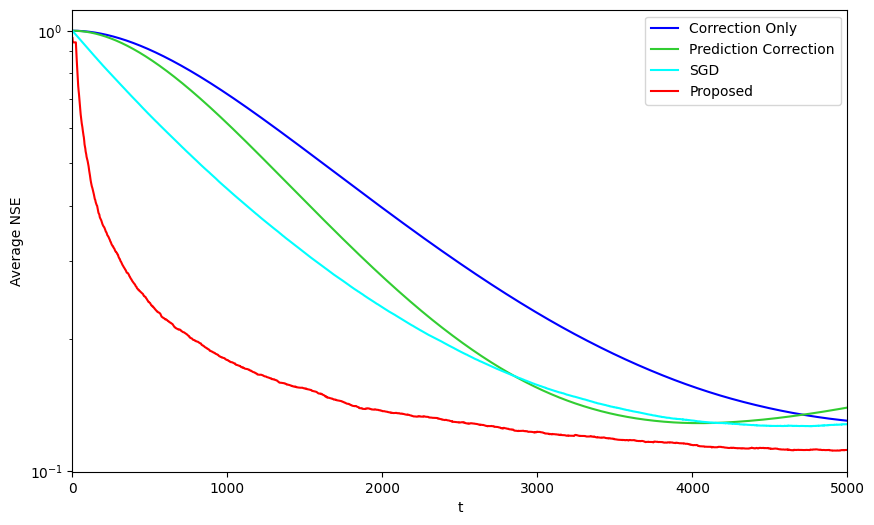

In [3]:
# 試行回数の設定
num_trials = 100

# パラメータの設定
N = 10
T = 5000
sparsity = 100
max_weight = 0.5
variance_e = 0.005
std_e = np.sqrt(variance_e)
K = 1
S_is_symmetric = True

seed = 42  # 基本のシード

# TV-SEMパラメータ
P = 1
C = 1
gamma = 0.999
alpha = 0.015
beta_pc = 0.015
beta_co = 0.02
beta_sgd = 0.02

# その他のパラメータ
r = 4  # window size
q = 20  # number of processors
rho = 0.15

# 試行ごとの処理を行う関数を定義
def run_trial(trial_seed):
    np.random.seed(trial_seed)  # シードを試行ごとに設定

    # データの生成
    S_series, X = generate_piecewise_X_K(N, T, S_is_symmetric, sparsity, max_weight, std_e, K)

    # 初期値の設定
    if S_is_symmetric:
        S_0 = generate_random_S(N, sparsity, max_weight)
    else:
        S_0 = generate_random_S_with_off_diagonal(N, sparsity, max_weight)
    S_0 = S_0 / norm(S_0)

    # モデルのインスタンス化（並列処理を無効化）
    tv_sem_pc = TimeVaryingSEM_PC_NONSPARSE(N, S_0, alpha, beta_pc, gamma, P, C)
    tv_sem_co = TimeVaryingSEM_PC_NONSPARSE(N, S_0, alpha, beta_co, gamma, 0, C)
    tv_sem_sgd = TimeVaryingSEM_PC_NONSPARSE(N, S_0, alpha, beta_sgd, 0, 0, C)
    tv_sem_pp = TimeVaryingSEM_PP_NONSPARSE_UNDIRECTED(N, S_0, r, q, rho)

    # 並列処理を無効化するために、直接関数を呼び出す
    estimates_pc, cost_values_pc = tv_sem_pc.run(X)
    estimates_co, cost_values_co = tv_sem_co.run(X)
    estimates_sgd, cost_values_sgd = tv_sem_sgd.run(X)
    estimates_pp = tv_sem_pp.run(X)

    # エラーの計算
    error_pc = []
    error_co = []
    error_sgd = []
    error_pp = []

    for i in range(T):
        error_pc.append(norm(estimates_pc[i] - S_series[i]) ** 2 / (norm(S_0 - S_series[i]) ** 2))
        error_co.append(norm(estimates_co[i] - S_series[i]) ** 2 / (norm(S_0 - S_series[i]) ** 2))
        error_sgd.append(norm(estimates_sgd[i] - S_series[i]) ** 2 / (norm(S_0 - S_series[i]) ** 2))
        error_pp.append(norm(estimates_pp[i] - S_series[i]) ** 2 / (norm(S_0 - S_series[i]) ** 2))

    return error_pc, error_co, error_sgd, error_pp

# 試行ごとのシードを作成
trial_seeds = [seed + i for i in range(num_trials)]

# 並列処理の実行
results = Parallel(n_jobs=num_trials)(
    delayed(run_trial)(trial_seed) for trial_seed in trial_seeds
)

# 結果の集計
error_pc_total = np.zeros(T)
error_co_total = np.zeros(T)
error_sgd_total = np.zeros(T)
error_pp_total = np.zeros(T)

for error_pc, error_co, error_sgd, error_pp in results:
    error_pc_total += np.array(error_pc)
    error_co_total += np.array(error_co)
    error_sgd_total += np.array(error_sgd)
    error_pp_total += np.array(error_pp)

# 平均の計算
error_pc_mean = error_pc_total / num_trials
error_co_mean = error_co_total / num_trials
error_sgd_mean = error_sgd_total / num_trials
error_pp_mean = error_pp_total / num_trials

# 結果のプロット
plt.figure(figsize=(10,6))
plt.plot(error_co_mean, color='blue', label='Correction Only')
plt.plot(error_pc_mean, color='limegreen', label='Prediction Correction')
plt.plot(error_sgd_mean, color='cyan', label='SGD')
plt.plot(error_pp_mean, color='red', label='Proposed')
plt.yscale('log')
plt.xlim(left=0, right=T)
plt.xlabel('t')
plt.ylabel('Average NSE')
plt.legend()
filename = (
    f'result_N{N}_'
    f'num_trials{num_trials}_'
    f'T{T}_'
    f'maxweight{max_weight}_'
    f'variancee{variance_e}_'
    f'K{K}_'
    f'Sissymmetric{S_is_symmetric}_'
    f'seed{seed}_'
    f'P{P}_'
    f'C{C}_'
    f'gammma{gamma}_'
    f'alpha{alpha}_'
    f'betapc{beta_pc}_'
    f'betaco{beta_co}_'
    f'betasgd{beta_sgd}_'
    f'r{r}_'
    f'q{q}_'
    f'rho{rho}_'
    f'numtrials{num_trials}_.png'
)
print(filename)
plt.savefig('./result/241220_mean/images/' + filename)
plt.show()
